# LSTM Time Series Forecasting with PyTorch

This Jupyter Notebook provides a full implementation of training an LSTM model using PyTorch on your pivot table dataset. The steps include data preparation, model definition, training, and evaluation.

---

## Table of Contents

1. [Data Preparation](#1)
   - Import Libraries
   - Load and Preprocess Data
2. [Define Dataset Class](#2)
3. [Split Data into Training and Validation Sets](#3)
4. [Create DataLoaders](#4)
5. [Define the LSTM Model](#5)
6. [Initialize Model, Loss Function, and Optimizer](#6)
7. [Training Loop](#7)
8. [Evaluate the Model](#8)
9. [Save the Model](#9)
10. [Conclusion](#10)

---


<a id="1"></a>
## 1. Data Preparation

### Import Libraries


In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error


### Load and Preprocess Data

Assuming your pivot table dataset in "../data/processed/2023_complete_pivot.parquet", with dates as the index and country-brand pairs as columns.


In [2]:
# Load the dataset
df_pivot = pd.read_parquet("../data/processed/2023_complete_pivot.parquet")

# Reset index to turn the date into a column
df_pivot = df_pivot.reset_index()

# Rename the 'index' column to 'date'
df_pivot = df_pivot.rename(columns={'index': 'date'})

# Melt the DataFrame to long format
df = df_pivot.melt(id_vars=['date'], var_name='id', value_name='value')

# Sort by 'id' and 'date'
df = df.sort_values(['id', 'date']).reset_index(drop=True)

# Convert 'date' to datetime if not already
df['date'] = pd.to_datetime(df['date'])

# Display the first few rows
df.head()


,date,id,value
0,2013-01-01,Aldovia-AIMST,0.000000
1,2013-01-02,Aldovia-AIMST,0.006284
2,2013-01-03,Aldovia-AIMST,0.123459
3,2013-01-04,Aldovia-AIMST,0.055607
4,2013-01-05,Aldovia-AIMST,0.000000


<a id="2"></a>
## 2. Define Dataset Class


In [3]:
class TimeSeriesDataset(Dataset):
    def __init__(self, sequences, targets, device):
        # Convert sequences and targets to torch tensors and move to GPU
        self.sequences = torch.FloatTensor(sequences).to(device)  # Shape: [num_samples, sequence_length]
        self.targets = torch.FloatTensor(targets).to(device)      # Shape: [num_samples]
    
    def __len__(self):
        return len(self.targets)
    
    def __getitem__(self, idx):
        # Retrieve sequences and targets directly from GPU tensors
        sequence = self.sequences[idx].unsqueeze(-1)  # Shape: [sequence_length, 1]
        target = self.targets[idx]
        return sequence, target


<a id="3"></a>
## 3. Split Data into Training and Validation Sets


In [4]:
# Parameters
cutoff_percentage = 0.8
sequence_length = 30  # Adjust based on your data
ratio_zeros = 0.5

# Determine the cutoff date for the split (e.g., last 20% for validation)
cutoff_date = df['date'].quantile(cutoff_percentage)
cutoff_date = np.datetime64(cutoff_date)

# Initialize lists for training and validation data
train_sequences = []
train_targets = []
val_sequences = []
val_targets = []

def generate_sequences(values, cutoff_idx, seq_length, zero_ratio):
    """
    Generate sequences and targets from the values array.
    
    Parameters:
    - values (np.ndarray): Array of values.
    - cutoff_idx (int): Index to split training and validation data.
    - seq_length (int): Length of each sequence.
    - zero_ratio (float): Maximum allowed ratio of zeros in a sequence.
    
    Returns:
    - train_seq, train_tgt, val_seq, val_tgt: Lists of training and validation sequences and targets.
    """
    num_values = len(values)
    
    # Training indices
    train_end = cutoff_idx - seq_length
    train_indices = np.arange(0, train_end)
    
    # Validation indices
    val_start = cutoff_idx
    val_end = num_values - seq_length
    val_indices = np.arange(val_start, val_end)
    
    # Function to create sequences and targets
    def create_seq_tgt(indices):
        seq = np.lib.stride_tricks.sliding_window_view(values, window_shape=seq_length)
        tgt = values[seq_length:]
        selected_seq = seq[indices]
        selected_tgt = tgt[indices]
        return selected_seq, selected_tgt
    
    # Create training sequences and targets
    train_seq, train_tgt = create_seq_tgt(train_indices)
    
    # Create validation sequences and targets
    val_seq, val_tgt = create_seq_tgt(val_indices)
    
    # Calculate ratio of zeros in each sequence
    train_zero_ratio = np.mean(train_seq == 0.0, axis=1)
    val_zero_ratio = np.mean(val_seq == 0.0, axis=1)
    
    # Filter sequences based on zero_ratio
    train_mask = train_zero_ratio <= zero_ratio
    val_mask = val_zero_ratio <= zero_ratio
    
    # Apply mask
    train_seq_filtered = train_seq[train_mask]
    train_tgt_filtered = train_tgt[train_mask]
    
    val_seq_filtered = val_seq[val_mask]
    val_tgt_filtered = val_tgt[val_mask]
    
    return train_seq_filtered, train_tgt_filtered, val_seq_filtered, val_tgt_filtered

# Iterate over each group and generate sequences
for name, group in df.groupby('id'):
    group = group.sort_values('date')
    values = group['value'].values
    dates = group['date'].values
    cutoff_index = np.searchsorted(dates, cutoff_date)
    
    # Ensure cutoff_index is within bounds
    cutoff_index = min(cutoff_index, len(values))
    
    # Generate sequences and targets
    train_seq, train_tgt, val_seq, val_tgt = generate_sequences(
        values, cutoff_index, sequence_length, ratio_zeros
    )
    
    # Append to the main lists
    train_sequences.append(train_seq)
    train_targets.append(train_tgt)
    val_sequences.append(val_seq)
    val_targets.append(val_tgt)

# Concatenate all sequences and targets
train_sequences = np.concatenate(train_sequences) if train_sequences else np.array([])
train_targets = np.concatenate(train_targets) if train_targets else np.array([])
val_sequences = np.concatenate(val_sequences) if val_sequences else np.array([])
val_targets = np.concatenate(val_targets) if val_targets else np.array([])

print(f'Total training samples: {len(train_sequences)}')
print(f'Total validation samples: {len(val_sequences)}')

# Convert to lists of sequences and targets for Dataset
train_sequences = list(train_sequences)
train_targets = list(train_targets)
val_sequences = list(val_sequences)
val_targets = list(val_targets)

Total training samples: 2218278
Total validation samples: 514141


<a id="4"></a>
## 4. Create DataLoaders


In [5]:
import os

batch_size = 2**16 # 64000

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create dataset instances with device parameter
train_dataset = TimeSeriesDataset(train_sequences, train_targets, device)
val_dataset = TimeSeriesDataset(val_sequences, val_targets, device)

# Optimize DataLoader parameters
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,  # Use almost full batch
    shuffle=True,
    num_workers=0,                 # Set to 0 to avoid multiprocessing issues with GPU tensors
    pin_memory=False               # Disable pin_memory as data is already on GPU
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,    # Use almost full batch
    shuffle=False,
    num_workers=0,                 # Set to 0 for the same reason as above
    pin_memory=False               # Disable pin_memory
)

print(f'Total training batches: {len(train_loader)}')
print(f'Total validation batches: {len(val_loader)}')

C:\Users\adria\AppData\Local\Temp\ipykernel_20064\3986715460.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  self.sequences = torch.FloatTensor(sequences).to(device)  # Shape: [num_samples, sequence_length]


Total training batches: 34
Total validation batches: 8


<a id="5"></a>
## 5. Define the LSTM Model


In [6]:
class LSTMForecastingModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super(LSTMForecastingModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Define LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # Define output layer
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Get the output from the last time step
        out = self.fc(out[:, -1, :])
        return out


<a id="6"></a>
## 6. Initialize Model, Loss Function, and Optimizer


In [7]:

model = LSTMForecastingModel(hidden_size=8).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


<a id="7"></a>
## 7. Training Loop


In [8]:
import time

num_epochs = 20  # Adjust based on your needs
last_epoch_time = time.time()

for epoch in range(num_epochs):
    model.train()
    train_losses = []
    
    for sequences, targets in train_loader:
        # No need to move data to device as it's already on GPU
        # sequences and targets are GPU tensors
        
        # Forward pass
        outputs = model(sequences)  # Shape: [batch_size, 1]
        loss = criterion(outputs.squeeze(), targets)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
    
    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for sequences, targets in val_loader:
            # No need to move data to device
            outputs = model(sequences).squeeze()
            loss = criterion(outputs, targets)
            val_losses.append(loss.item())
    
    elapsed_time = time.time() - last_epoch_time
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {np.mean(train_losses):.6f}, '
          f'Val Loss: {np.mean(val_losses):.6f}, '
          f'Elapsed time: {elapsed_time:.2f} seconds')
    last_epoch_time = time.time()

Epoch [1/20], Train Loss: 0.072314, Val Loss: 0.029642, Elapsed time: 59.62 seconds
Epoch [2/20], Train Loss: 0.010497, Val Loss: 0.001920, Elapsed time: 58.50 seconds
Epoch [3/20], Train Loss: 0.001964, Val Loss: 0.001920, Elapsed time: 58.33 seconds
Epoch [4/20], Train Loss: 0.001873, Val Loss: 0.001920, Elapsed time: 58.23 seconds
Epoch [5/20], Train Loss: 0.001871, Val Loss: 0.001920, Elapsed time: 58.96 seconds
Epoch [6/20], Train Loss: 0.001870, Val Loss: 0.001919, Elapsed time: 60.95 seconds
Epoch [7/20], Train Loss: 0.001870, Val Loss: 0.001919, Elapsed time: 58.29 seconds
Epoch [8/20], Train Loss: 0.001870, Val Loss: 0.001919, Elapsed time: 58.62 seconds
Epoch [9/20], Train Loss: 0.001870, Val Loss: 0.001919, Elapsed time: 58.79 seconds
Epoch [10/20], Train Loss: 0.001870, Val Loss: 0.001919, Elapsed time: 60.14 seconds
Epoch [11/20], Train Loss: 0.001870, Val Loss: 0.001919, Elapsed time: 58.95 seconds
Epoch [12/20], Train Loss: 0.001870, Val Loss: 0.001919, Elapsed time: 58.

<a id="8"></a>
## 8. Evaluate the Model

### Calculate Metrics


In [17]:
model.eval()
predictions = []
actuals = []
i = 0
with torch.no_grad():
    for sequences, targets in val_loader:
        outputs = model(sequences)
        predictions.extend(outputs.squeeze().cpu().numpy())
        actuals.extend(targets.cpu().numpy())
        i += 1
mae = mean_absolute_error(actuals, predictions)
rmse = mean_squared_error(actuals, predictions, squared=False)

print(f'Validation MAE: {mae:.4f}')
print(f'Validation RMSE: {rmse:.4f}')


Validation MAE: 0.0322
Validation RMSE: 0.0438


c:\dev\Bonkis-Jake\venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Visualize Predictions


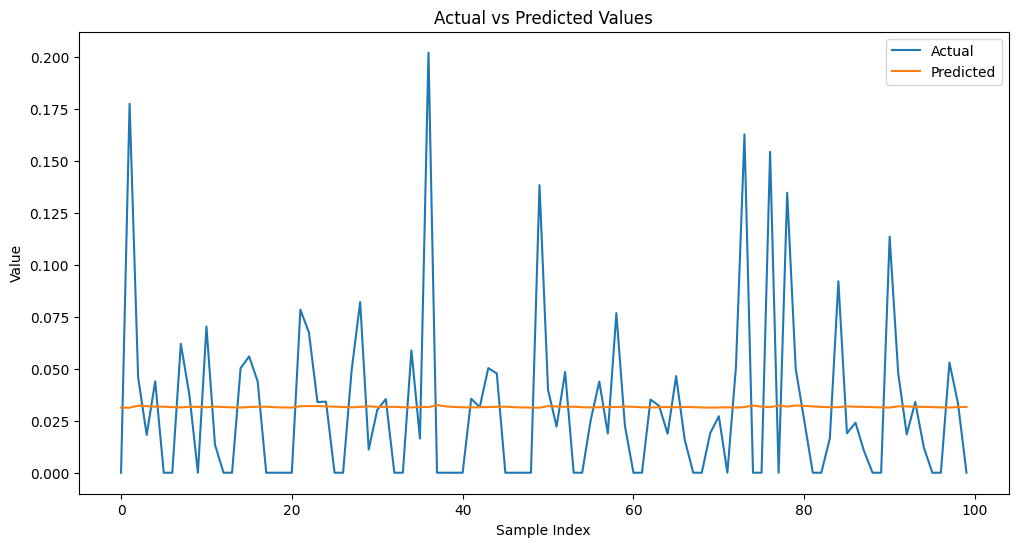

In [16]:
# Plot the first 100 predictions vs actuals
plt.figure(figsize=(12, 6))
plt.plot(actuals[:100], label='Actual')
plt.plot(predictions[:100], label='Predicted')
plt.legend()
plt.title('Actual vs Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.show()


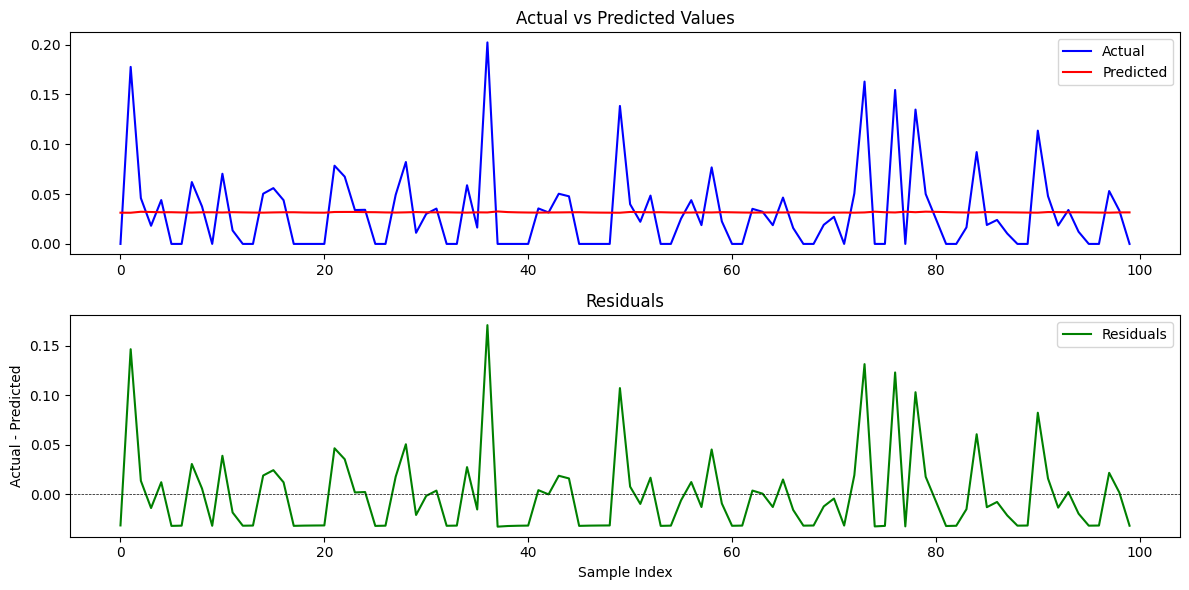

In [ ]:
import matplotlib.pyplot as plt

# Calculate residuals
residuals = np.array(actuals[:100]) - np.array(predictions[:100])

plt.figure(figsize=(12, 6))

# Actual vs Predicted
plt.subplot(2, 1, 1)
plt.plot(actuals[:100], label='Actual', color='blue')
plt.plot(predictions[:100], label='Predicted', color='red')
plt.legend()
plt.title('Actual vs Predicted Values')

# Residuals
plt.subplot(2, 1, 2)
plt.plot(residuals, label='Residuals', color='green')
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.legend()
plt.title('Residuals')
plt.xlabel('Sample Index')
plt.ylabel('Actual - Predicted')

plt.tight_layout()
plt.show()

<a id="9"></a>
## 9. Save the Model


In [14]:
torch.save(model.state_dict(), 'lstm_forecasting_model.pth')


<a id="10"></a>
## 10. Conclusion

You've successfully trained an LSTM model on your pivot table dataset using PyTorch. You can now use this model to make predictions on future data or further refine it by tuning hyperparameters or incorporating additional features.

---

## Additional Notes

- **Adjust Hyperparameters**: Experiment with `sequence_length`, `hidden_size`, `num_layers`, `batch_size`, and `num_epochs` to optimize performance.
- **Scaling Data**: If your data has varying scales, consider scaling or normalizing it.
- **Early Stopping**: Implement early stopping to prevent overfitting if necessary.
- **Feature Engineering**: Even without exogenous variables, adding features like day of the week or month can help capture temporal patterns.

## Example: Making Future Predictions


In [ ]:
def predict_future(model, initial_sequence, prediction_length):
    model.eval()
    predictions = []
    sequence = initial_sequence.copy()
    
    for _ in range(prediction_length):
        seq_input = torch.FloatTensor(sequence[-sequence_length:]).unsqueeze(0).unsqueeze(-1).to(device)
        with torch.no_grad():
            pred = model(seq_input)
        pred_value = pred.item()
        predictions.append(pred_value)
        sequence = np.append(sequence, pred_value)
    return predictions

# Example usage:
# Get the last sequence from the validation data
latest_sequence = val_sequences[-1]
future_predictions = predict_future(model, latest_sequence, prediction_length=7)

print("Future Predictions:", future_predictions)


Future Predictions: [0.031216949224472046, 0.03137993812561035, 0.03146323561668396, 0.03151354193687439, 0.03154641389846802, 0.03157013654708862, 0.031588971614837646]
